这篇文章通过 手写数字识别 来讨论分类问题

In [1]:
# 准备工作
#准备工作

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# 基本包的导入
import numpy as np
import os

# 画图相关
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# 忽略警告
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='internal')

# 图片存储目录
PROJECT_ROOT_DIR = '../'
CHAPTER_ID = 'classifiction'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("保存图片:", fig_id)
    
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### MNIST 数据集


作为机器学习的hello world 项目，每当有新的机器学习算法时，该数据集就会被用于评估该模型的性能。

In [2]:
from sklearn.datasets import fetch_mldata 
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

如上方法通过 函数从网络上下载数据集，默认保存在 ` $HOME/scikit_learn_data.`目录。  
通过sklearn 下载的数据都有以下结构：  
1. DESCR：数据集的描述
2. data： 数据集的数据，每行是一个实例， 每列是一个特征。
3. target: 数据集的标签，即需要预测的值。

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

如上，包含该70000张图片，每张图片有28 * 28 个像素，共计784个特征。   
可以对每张图片进行可视化。

保存图片: some_digit_plot


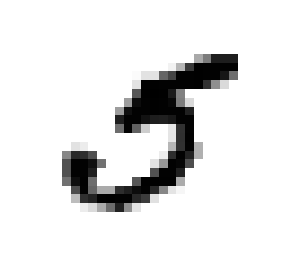

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

In [7]:
y[36000] #可以看到图片和标签都为5.

5.0

In [8]:
# 定义一个函数来查看图片
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

保存图片: more_digits_plot


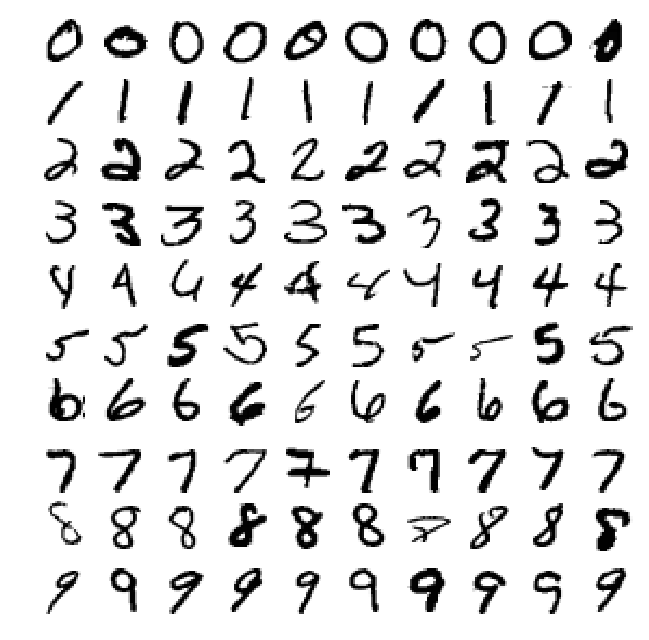

In [9]:
# 查看更多图片， 10 * 10
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row: (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:30600:600],  X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [10]:
# 切分测试集用于后续预测
X_train, y_train, X_test, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
# 由于该训练集对于顺序没有要求，不像股票数据或者天气数据。不是一般性，将其随机打乱
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y[shuffle_index]

### 训练一个二元分类器

从一个简单的为开始识别手写数字。首先判断一个实例是否为5.  
目标向量：

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5

array([False, False, False, ..., False, False, False])

现在可以找一个分类器对其训练。从 随机梯度下降分类器开始，优点在神将网络中也有提到，能快速处理大的数据集, 非常适合在线学习。

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])  # 可以看到对图片 5 预测正确， 返回true。

array([ True])

### 评估性能

评估分类模型的精确度要比回归模型复杂的多。下面使用交叉验证来对该模型进行评估：

In [14]:
# 交叉验证， 为了保证随机抽样，可以自定义交叉验证方法，进行随机抽样。
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96525, 0.967  , 0.9657 ])

In [15]:
# 进行随机抽样，交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))
    

0.9611
0.9464
0.96815


In [16]:
# 看起来精确度还不错，下面定义一个最简单的分类器：
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) #永远返回0， 即预测等于5失败。

In [17]:
# 猜一下精确度
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9072 , 0.908  , 0.91375])

上述结果也有90的精确度，因为对于本次训练来说，不是5的比率在90%， 因此无论怎么训练，精确度最低都在90%。  
这说明了为什么精度通常不是用于分类器的首选性能度量， 特别是在某些类出现的比较频繁时。

### Confusion Matrix : 混淆矩阵

In [18]:
# 使用cross_val_predict
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred.shape

(60000,)

该函数与cross_val_score()类似，不过结果不是交叉验证的分数，而是每个测试fold的预测值。
这意味着可以得到一个 “清晰” 的预测值， 即该值所对应的实例不参与训练。

In [19]:
# 得到混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53768,   811],
       [ 1314,  4107]])

得到如上混淆矩阵：每行代表真实值，每列代表预测值。
比如第一行表示 为非5(nagative class)的图像数， 其中52849张( true nagative) 预测分类正确；1730张(false nagative) 图片预测失败。
第二行表示 为5(positive class) 的图像数，843预测失败，4587张测成功，共计60000张图片。

最理想的模型计算得到的混淆只包括 true positives 和 true negatives 两项。


In [20]:
confusion_matrix(y_train_5, y_train_5) #假设y_train_5就是预测值。

array([[54579,     0],
       [    0,  5421]])

混淆矩阵包含太多可用的信息。可以使用以下方法衡量分类器的准确度。  
precision = TP / (TP + FP)

这里存在一个问题。假设训练集中只有单一的正确值(5的图片只有一张)， 那么预测正确的话，精确度就是100%。
但是模型一般会忽略正确值而预测错误，因此这种精确度 不是非常有用。  
因此经常需要结合 recall 这种衡量方法， 也叫做 sensitivisy 和 true positive rate。  
计算方法为  recall = TP / (TP + FN), 通常表示预测正确的占比。  

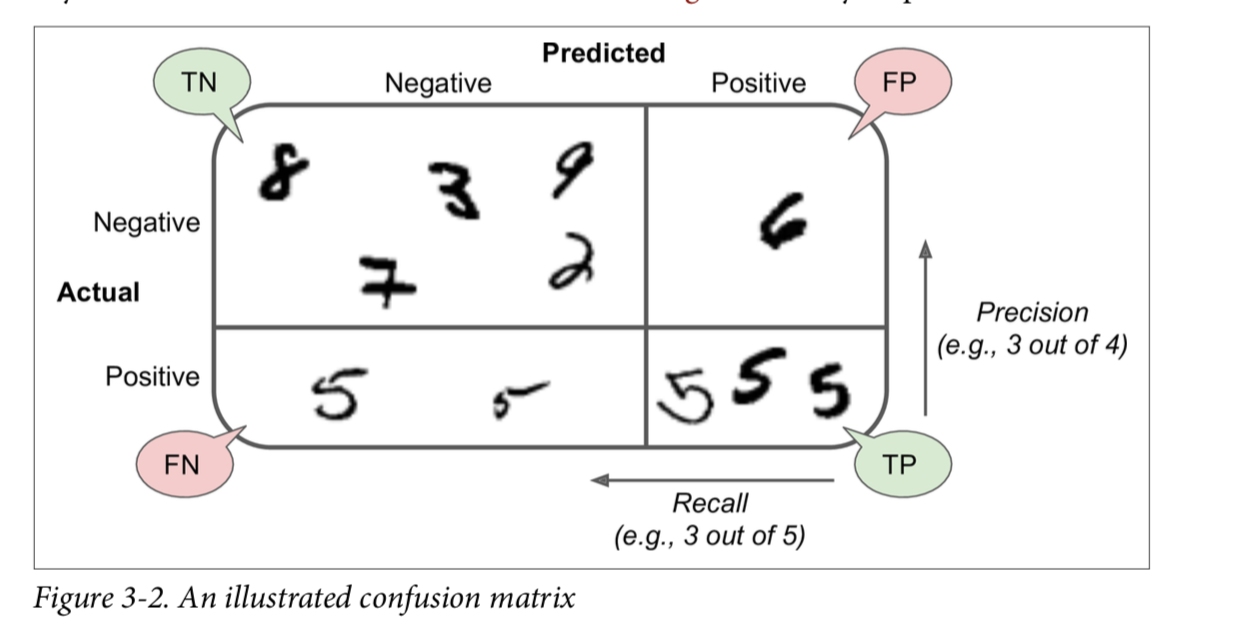

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 4587 / (4587 + 1730)

0.835095567303782

In [22]:
recall_score(y_train_5, y_train_pred) # 4587 / (4587 + 834)

0.7576092971776425

以上结果相比之前的度量方法有不同。  
比如只有84%的精确度，并且只识别出了68%的正确图片5.

recall 越高，说明模型对正样本的识别能力越强，precision 体现了模型对负样本的区分能力，precision越高，说明模型对负样本的区分能力越强。  
F1-score 是两者的综合。F1-score 越高，说明分类模型越稳健。

更方便的，可以将精确度和召回率 组合为一个度量方法， 称为F1 分数，可以理解为两个度量的调和平均值。  
F1可以用于不同分类器的比较。  
此计算方法会加重 较小值的权重，因此在精确度和recall 都很高且接近的时候，才可以较高的F1分数。
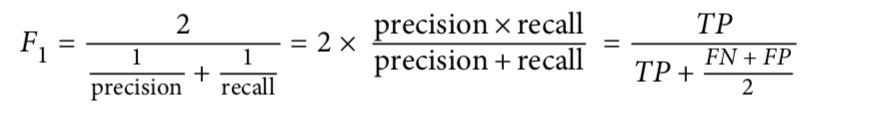

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7944675500531966

F1评分倾向于具有相似精度和召回率的分类器。但是某个情况比较在意精确度，某些情况比较在意recall。  
但是不可能增加精确度的同时减少recall， 这称为 `precision/recall tradeoff`

#### 精确度/召回率 权衡

可以这样理解：对于二分类问题，当精确度超过某一阈值， 可认为属于该类，否则就是相反类。
如下图所示比较清晰明显。
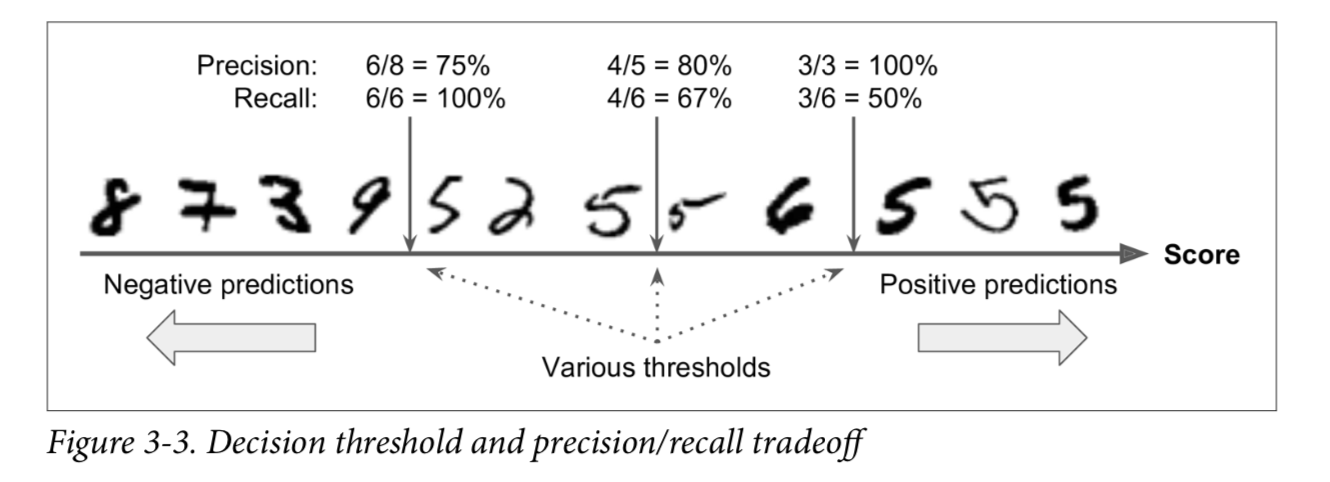

可以看到不同的阈值对precision/recall的影响。很明显，低阈值会增加召回率，降低精确度。

In [24]:
y_scores = sgd_clf.decision_function([some_digit])

y_scores

array([86544.73170214])

这里`decision_function()`返回每个实例对应的值， 可以设定阈值预测是不是图片5.
如下：

In [25]:
# 使用阈值来决定不同precision/recall
# 
threshold = 0 # 较小阈值
y_some_digit_pred = (y_scores > threshold)


In [26]:
y_some_digit_pred  # 与阈值比较

array([ True])

In [27]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

问题就变成怎么选择一个合适的阈值：

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [29]:
y_scores

array([-562845.59870005,  133393.78557548, -521662.5579884 , ...,
       -228305.14612052, -888758.03394582, -181049.88614411])

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [31]:
def plot_precision_recall_vs_threshold(precisions, recall, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=15)
    plt.ylim([0, 1])

保存图片: precision_recall_vs_thresold_plot


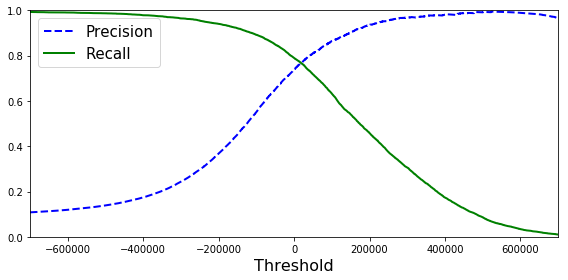

In [32]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_thresold_plot")
plt.show()

从上图 可以看出，随着阈值的调整，精度度和召回率也在变化，目标就是找到一个最合适的值。

In [33]:
(y_train_pred == (y_scores > 0)).all()

False

In [34]:
(y_train_pred == (y_scores > 70000)).all()

False

In [35]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.8318049653321404

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.6860357867552113

In [37]:
def plot_precision_vs_recall(precisions, recalls):
    
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

保存图片: precision_vs_recall_plot


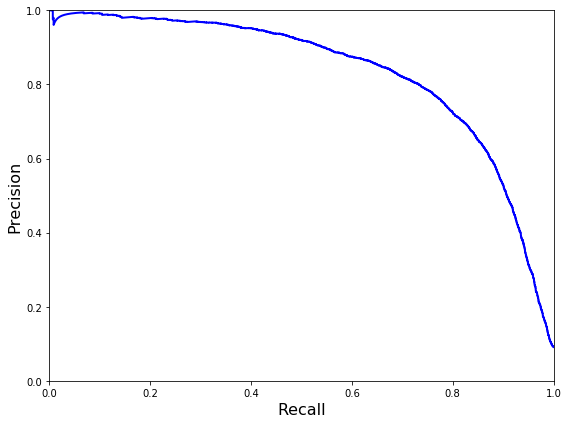

In [38]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

PR曲线：可以看到precision开始大幅下降到召回率为80%处。此时就可以选择一个平衡方案，拨入召回率在60%左右处的地方。 

### ROC 曲线
针对二分类问题的另一种工具。

In [39]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

保存图片: roc_curve_plot


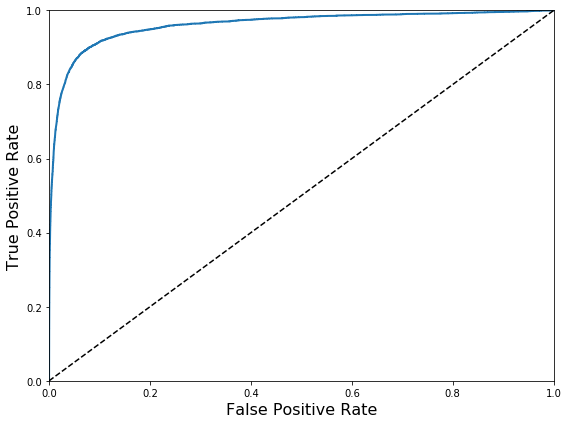

In [41]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

解释一下这个图：ROC为受试者工作特征曲线，也是二分类问题的一个工具。
其非常近似于precision/recall 曲线。不用在于该曲线是true positive rate(召回率)相对于false positive rate的变化。后者是错样本被分类正确的比例，等于(1 - true negative rate, 负样本被分类为负样本的比例)。
此图也是一个平衡。召回率越高， 分类器产生的FPR就越高。虚线代表一个随机的分类器，好的分类器应往左上角尽量远离该虚线。

另一种方式是测量曲线下的面积(AUC)。一个好的分类器表现为ROC的 AUC = 1。随机分类器则为0.5.
sklearn中有方法计算RUC， 如下：

In [49]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)  # 接近1

0.9608748772981834

In [43]:
# 使用随机森林分类器
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,  method="predict_proba")

In [44]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

保存图片: roc_curve_comparison_plot


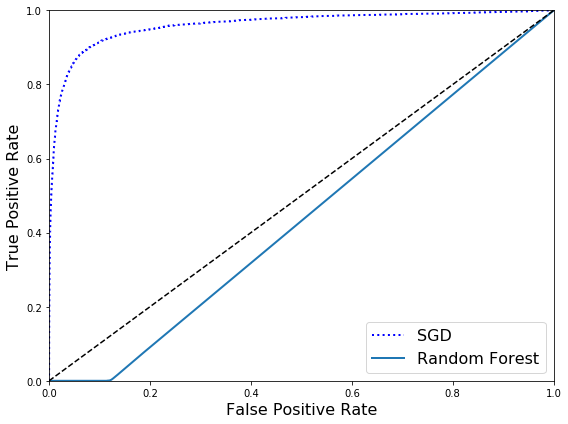

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

上图有错误，RF的效果应该更好，后续研究改正。

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.43982183064038016

In [47]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9822251481237656

In [48]:
recall_score(y_train_5, y_train_pred_forest)

0.8256779192030991

### 多分类

上面讨论的是二分类问题。但是比如RF， NB(naive Bayes)都可以处理多分分类问题。而不像线性分类， SVM等只能处理二分类，当然通过一定的策略也可以多分类。

比如有两种方法：像手写数字识别，可以分别计算每中图片得到的分数，去最高值，这种叫做one-versus-all(OvA).
另一种就是 两两比较分类，one-versusone(OvO),共需计算n*(n-1)次。结果就是看哪个分类赢的次数多。

In [52]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) 

array([5.])

In [53]:
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score

array([[-115853.93816885, -528150.46399939, -431483.13589734,
        -130145.86264307, -330917.6865707 ,   71668.60640146,
        -609215.55126424, -492265.64210917, -659164.52175754,
        -620944.88834559]])

In [54]:
np.argmax(some_digit_score)

5

In [56]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [57]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [58]:
len(ovo_clf.estimators_)

45

In [59]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [60]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0.2, 0. ]])

In [61]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85162967, 0.840042  , 0.84967745])

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90821836, 0.91274564, 0.90963645])

In [65]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx # 混淆矩阵

array([[5730,    4,   23,    9,   10,   50,   49,    9,   37,    2],
       [   2, 6476,   42,   30,    6,   36,   10,   13,  115,   12],
       [  52,   33, 5332,  101,   90,   28,   89,   52,  166,   15],
       [  50,   38,  126, 5345,    2,  244,   35,   59,  135,   97],
       [  20,   22,   39,   13, 5369,    8,   51,   29,   88,  203],
       [  64,   43,   32,  181,   79, 4604,  115,   25,  176,  102],
       [  30,   26,   47,    2,   48,   89, 5629,    3,   44,    0],
       [  22,   21,   68,   34,   58,   11,    6, 5794,   13,  238],
       [  46,  152,   70,  164,   14,  146,   52,   20, 5031,  156],
       [  41,   27,   28,   88,  161,   41,    4,  185,   80, 5294]])

In [66]:
def plot_confusion_matirx(matrix):
    """
    color and colorbar
    """
    fig = plt.figure(figsize=(8,8))
    ax=fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

保存图片: confusion_matrix_plot


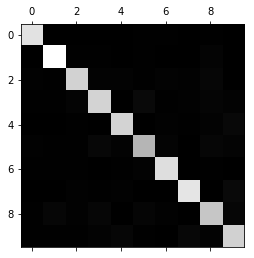

In [67]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [71]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

保存图片: confusion_matrix_errors_plot


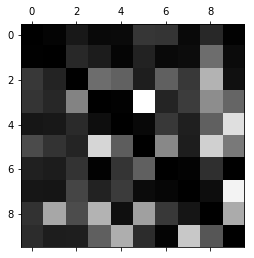

In [72]:
np.fill_diagonal(norm_conf_mx, 0)  #设置对角元素
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()


保存图片: error_analysis_digits_plot


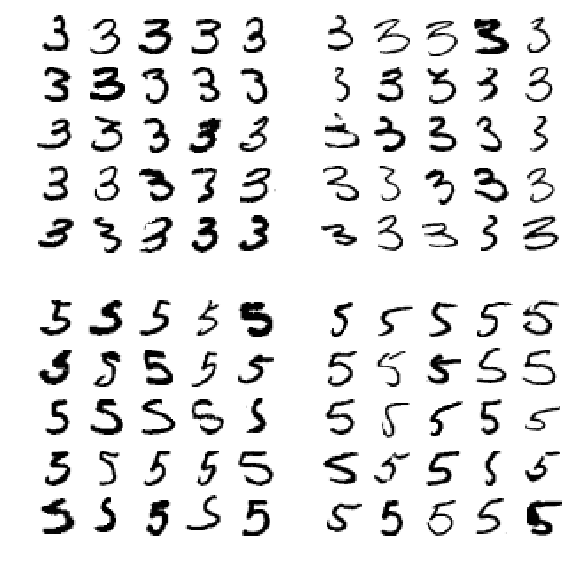

In [80]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

### 多标签分类